In [1]:
import numpy as np
import pandas as pd
# load mat file
import scipy

In [2]:
mat = scipy.io.loadmat('datasets/irmdata/alyawarradata.mat')
d = mat['Rs']
d.shape

(104, 104, 26)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append("/Users/aleix11alcacer/Projects/archetypes")

In [5]:
from archetypes.algorithms.torch import NAA
from models import BiAA, DBiAA
import torch

In [118]:
data = torch.tensor(d).float().reshape(d.shape)

model = NAA((16, 16), d.shape, relations=[0, 0], degree_correction=False, membership="hard", device="cpu")
model.fit(data, n_epochs=5_000, learning_rate=0.05)

  0%|          | 0/5000 [00:00<?, ?it/s]

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

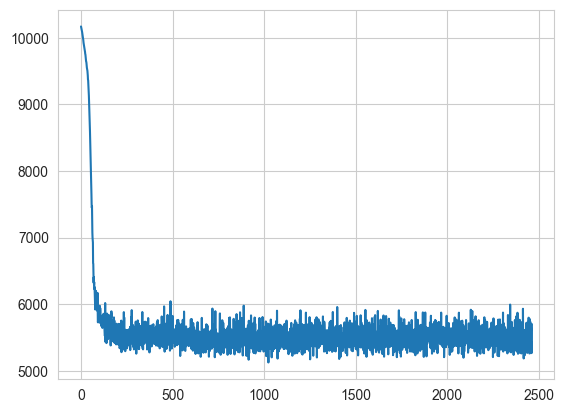

In [116]:
import matplotlib.pyplot as plt

plt.plot(model.losses)
plt.show()

In [113]:
from archetypes.visualization import heatmap
from archetypes.datasets import sort_by_archetype_similarity

In [114]:
alphas = [a.detach().numpy() for a in model.A]
estimated_archetypes = model.Z.detach().numpy()

for a in alphas:
    print(a.shape)
    
print(estimated_archetypes.shape)

(104, 16)
(104, 16)
(16, 16, 26)


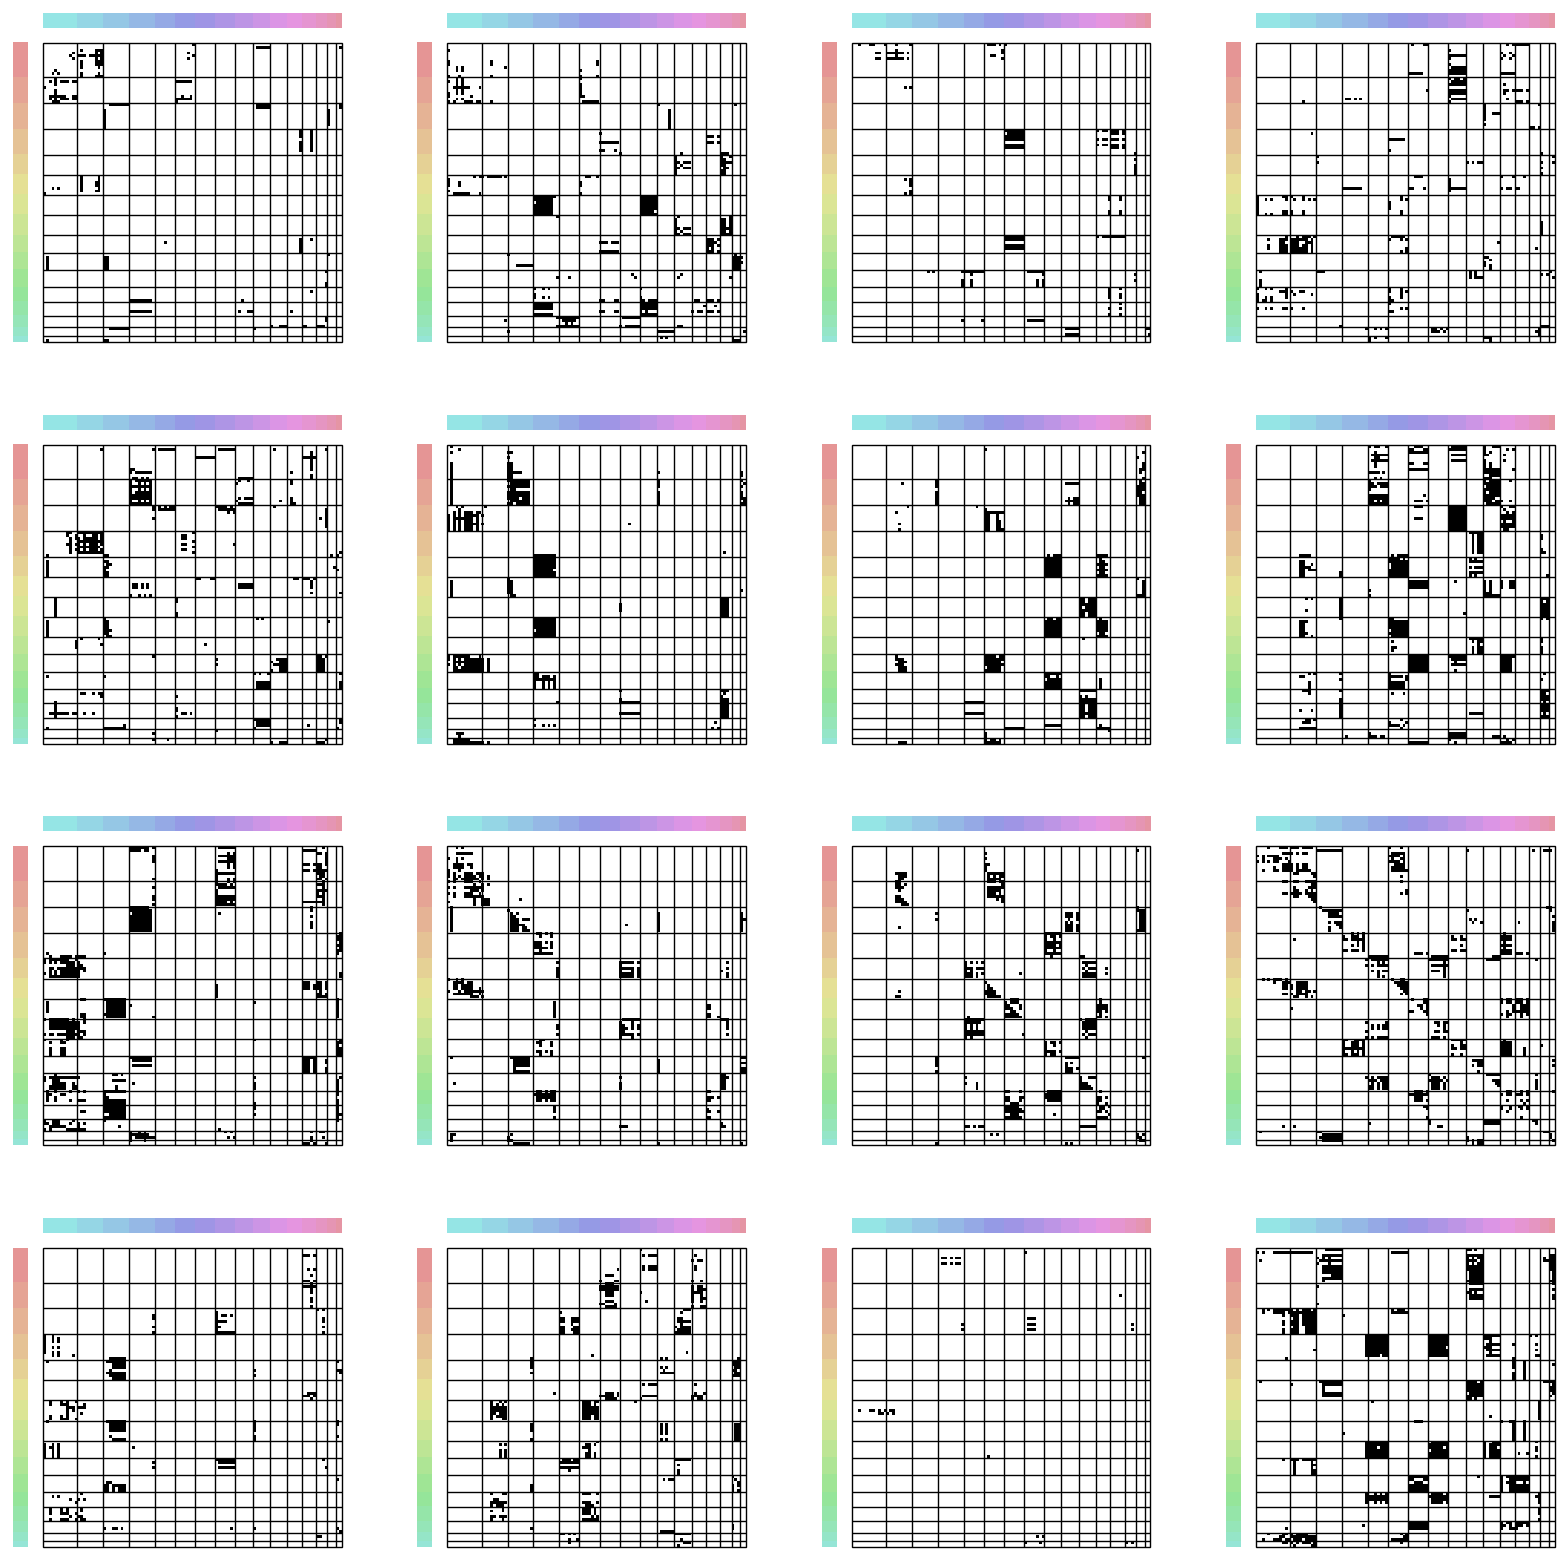

In [90]:

fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axs.flatten()):
    data_s, info_s = sort_by_archetype_similarity(data[:, :, i], alphas, estimated_archetypes)
    heatmap(data_s, info_s["labels"], info_s["n_archetypes"], info_s["scores"], ax=ax)

plt.show()

In [ ]:
import pandas as pd

df = pd.DataFrame(mat['features'][:, [3, 4, 8]], columns = ["Gender", "Age", "Kinship"])
group = model.A[1].detach().numpy().argmax(axis=1)
df["group"] = group
# cut age into 6 bins: 0-7, 8-14, 15-29, 30-44, 45-59, 60-99
df["Age"] = pd.cut(df["Age"], bins=[0, 7, 14, 29, 44, 59, 99])
# mutate gender from 0,1 to M,F
df["Gender"][df["Gender"] == 1] = "M"
df["Gender"][df["Gender"] == 2] = "F"

df.head()

In [ ]:
# for each group plot a histogram for each feature
import seaborn as sns

fig, axs = plt.subplots(3, 16, figsize=(15, 5), gridspec_kw={'height_ratios': [2, 6, 4]})

for j, col in enumerate(df.columns[:-1]):
    count_max = df.groupby("group")[col].count().max()
    
    for i, ax in enumerate(axs[j]):
        df_i = df[df.group == i]
        sns.countplot(y=df_i[col], ax=ax, order=df[col].unique(), stat="count", color="black")
    
        # hide x labels
        ax.set_xticklabels([])
        ax.set_xlabel("")
        if i != 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])
        
        # set x limits
        ax.set_xlim(0, count_max)
        
        # remove axis except y line
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        # remove ticks
        ax.tick_params(axis='both', which='both', length=0)

plt.show()


In [ ]:
pd.read_